<a id="top"></a>

<div style="display: flex; justify-content: space-between;">
    <a href="../notebook/01 - Business & Data Understanding.ipynb" style="float: left; padding: 10px; text-decoration: none; background-color: #007bff; color: white; border-radius: 5px;">Previous</a>
    <a href="../notebook/03 - Predictive Analysis.ipynb" style="float: right; padding: 10px; text-decoration: none; background-color: #007bff; color: white; border-radius: 5px;">Next</a>
</div>

In [1]:
# Importing necessary libraries
import warnings 
import numpy as np  
import pandas as pd 
import seaborn as sns   
import matplotlib.pyplot as plt 
import scipy.stats as stat

# Hide warning issues to prevent unnecessary output clutter
warnings.filterwarnings("ignore")

# Setting the maximum column width for pandas display to 100 characters
pd.options.display.max_colwidth = 100

# Applying the 'seaborn' style to matplotlib for consistent and visually appealing plots
plt.style.use('seaborn')   

# Adding custom scripts to the Python path
import sys
sys.path.append('../scripts')
from helper import *

<a id="numerical"></a>
## <b><span style='color:darkturquoise'>Section 3 |</span><span style='color:darkblue'> Uncovering Insights in Customer Behavior</span></b>

____

As discussed earlier in the Section 1, the ultimate goal is to decrease customer churn, and to this end, we firstly need to identify the characteristics of customers who churned. This identification will shed light on the possible contributing factors of the churn, and enable the Customer Success Manager as the key stakeholder of this project to take necessary action to mitigate the business impacts of the customer churn. This section explores the dataset by relating every feature (both categorical and numerical) to the target variable, i.e., `Churn`. By associating the features to `Churn` and comparing each feature based on the customer churn status (churn vs non-churn), it is expected to gain an understanding of the customers' characteristics who no longer make any purchases in the telco service.

To make this section more structured, we mainly divide Section 3 into three groups that do not overlap. The division will be further detailed by using questions to guide the analysis. However, before moving on to the first subsection, we will check out the overall churn rate in the telecommunication company as this will be the starting point for our analysis and data modeling, i.e., the overall churn rate in the telecommunication company.

1. **Customer Demographics (Who the Churned Customer Is?)**

    These factors provide context about the customer's personal background and characteristics.

    - Does the gender of a customer affect their likelihood to churn?
    - Are senior citizens more likely to churn compared to non-senior citizens?
    - Does having a partner influence the customer's likelihood of churning?
    - Do customers with dependents churn at a different rate than those without?

2. **Service Subscriptions (What Services the Churned Customer Uses?)**
    
    These factors relate to the type of service the customer subscribes to, which might impact their satisfaction and retention.

    - How long has the customer been with the company?
    - Does having a phone service affect churn rates?
    - Is there a difference in churn between customers with multiple phone lines vs. a single line?
    - Does the type of internet service (DSL, Fiber, No service) influence churn?
    - Do customers who subscribe to value-added services (OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, Streaming) experience fewer churn than those who do not?

3. **Billing and Payment (How the Churned Customer Pays?)**
    
    These factors represent the customer's financial capability, ease of transaction, and whether the cost of the service is perceived as worth it.

    - Do customers on month-to-month contracts churn more than those on one- or two-year contracts?
    - Does opting for paperless billing impact churn rates?
    - Do customers with certain payment methods (e.g., electronic check vs. credit card) churn more frequently?
    - How do monthly charges and the total amount spent by customers influence their likelihood of churn?

4. **Cross-Category Analysis (What Drives Customer Loyalty?)**

    These factors reflect the customer's overall satisfaction, perceived value across categories, and their likelihood to remain loyal.

    - How does tenure interact with contract type and monthly charges to impact churn?
    - How does the bundling of InternetService, PhoneService, and additional services relate to churn behavior?
    - What role does the combination of tenure, contract type, and service add-ons play in churn reduction?

**Note:**

This section is structured in this way: We firstly show the count of each categories by churn status to get the overview of the feature, specifically about how customer churn varies across categories. Nonetheless, since simple count only provides us with an incomplete story, we incorporate churn rate per category in a feature to give us a better understanding the churn risk. Afterwards, we conduct a hypothesis test to determine if there is a significant statistical relationship between the churn status and the variables. If the statistical test shows a significant association, it means there is a notable relationship between customer churn and the category in question. This insight helps us identify which categories are more prone to churn, allowing us to implement targeted strategies to address these specific areas and potentially reduce overall churn rates.

In [2]:
# Import the dataset from a CSV file into a pandas DataFrame
df = pd.read_csv('../data/data.csv')

<a id="basic"></a>
### <b><span style='color:darkblue'> 3.1 Data Preparation: Cleaning and Creating</span></b>

In this section, we performe a series of data preparation. The process here is primarily aimed for preparing data for an analysis on customer churns behavior. 

The `customerID` column is removed as it is not useful for analysis or modeling. This column likely serves as a unique identifier for each customer, which does not contribute to predicting customer churn or any other outcomes we are interested in. Therefore, it is dropped from the DataFrame to avoid unnecessary complexity in the model.


In [3]:
# Remove the 'customerID' column
df.drop(columns='customerID', inplace=True)

The `TotalCharges` column contains missing values that need to be addressed before proceeding with analysis. In this step, we fill the missing values with the most frequent value (mode) of the `TotalCharges` column. This is a common approach for handling missing numerical data, especially when the mode represents a reasonable approximation for missing values.

In [4]:
# Handle missing values in the 'TotalCharges' column
df.fillna(value={'TotalCharges': df['TotalCharges'].mode()[0]}, inplace=True)

To streamline data analysis and ensure consistency, we combined the value "No internet service" with the value "No" for the variables OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport, StreamingTV, and StreamingMovies. This transformation was applied only when the InternetService variable was "No". The rationale behind this adjustment is that customers without internet service cannot access these features, making "No internet service" logically equivalent to "No." By consolidating these values, we reduced redundancy and simplified the dataset, enabling more straightforward and meaningful analyses of service subscriptions and their impact on churn.

In [5]:
# List of columns to update, representing customer services that depend on Internet access
columns_to_update = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Iterate over each column in the list
for col in columns_to_update:
    # Update rows where 'InternetService' is 'No' by replacing 'No internet service' with 'No'
    df.loc[df['InternetService'] == 'No', col] = 'No'

The same thing we apply to the Multiplelines variable, we combined the value "No phone service" with the value "No" for the variables MultipleLines. This transformation was applied only when the PhoneService variable was "No".

In [6]:
# Replace 'No phone service' with 'No' where PhoneService is 'No'
df.loc[df['PhoneService'] == 'No', 'MultipleLines'] = 'No'

We categorize customers into meaningful groups based on total billing, monthly billing, and tenure. This process helps in identifying and analyzing patterns in more detail.

In [7]:
# Group customers into high, medium, low based on TotalCharges quartiles
df['TotalChargesCategory'] = pd.qcut(df['TotalCharges'], q=3, labels=['Low', 'Medium', 'High'])

# Create monthly charges bins
df['MonthlyChargesCategory'] = pd.qcut(df['MonthlyCharges'], q=3, labels=['Low', 'Medium', 'High'])

# Create tenure bins
df['TenureCategory'] = pd.cut(df['tenure'], bins=[0, 12, 24, 36, 48, 60, 72], labels=['0-12', '13-24', '25-36', '37-48', '49-60', '61-72'])

Customers who subscribe to multiple services, such as internet, streaming, or technical support, often show a higher level of interaction with the company. To measure that level of engagement, we will calculate the total number of services a customer uses. This metric is referred to as **TotalServiceCount**.

In [8]:
def total_service(row):
    # Define a list of columns representing additional services a customer might subscribe to
    services = [
        row['OnlineSecurity'], row['OnlineBackup'], row['DeviceProtection'], row['TechSupport'],
        row['StreamingTV'], row['StreamingMovies']
    ]
    # Count the number of additional services the customer has subscribed to
    additional_services = sum([1 if x == 'Yes' else 0 for x in services])

    return additional_services # Return the total count of subscribed additional services

# Apply the 'total_service' function to each row of the DataFrame
df['TotalServiceCount'] = df.apply(total_service, axis=1)

Lastly, we define a **ServiceBundle** column to group customers based on their subscription to internet and phone services. The goal is to provide a clear understanding of the type of services a customer has, combining basic services (internet and phone) with the count of additional services. This column will serve as a useful variabel for further analysis, such as identifying patterns in customer churn or bundling preferences.

In [9]:
def service_bundle(row):    
    # Define the service bundle based on the availability of Internet and Phone services
    if row['InternetService'] == "No" and row['PhoneService'] == "No":
        return "No Service"  # No service
    elif row['InternetService'] != "No" and row['PhoneService'] == "No":
        return f"{row['InternetService']}_Internet Only"  # Only internet service
    elif row['InternetService'] == "No" and row['PhoneService'] == "Yes":
        return "Phone Only"  # Only phone service
    else:
        # Both internet and phone services are available, with the count of additional services
        return f"{row['InternetService']}_Internet + {row['TotalServiceCount']} Add-ons"

# Apply the service_bundle function to each row of the DataFrame and create a new 'ServiceBundle' column
df['ServiceBundle'] = df.apply(service_bundle, axis=1)

<a id="basic"></a>
### <b><span style='color:darkblue'> 3.2 Who the Churned Customer Is?</span></b>

Analyzing customer demographics is a crucial step in understanding the factors that influence churn status. Demographic attributes such as gender, partner, and whether the customer is a senior citizen or has dependents often provide valuable insights into customer behavior and loyalty. These characteristics can reveal specific patterns or trends, such as which groups are more likely to leave the service and why. By identifying demographic factors strongly associated with churn, businesses can develop targeted strategies to retain high-risk customers, improve overall satisfaction, and enhance customer lifetime value. This analysis also serves as a foundation for creating personalized marketing campaigns and optimizing customer service efforts, ensuring that the company addresses the needs of its diverse customer base effectively.

#### **Q1. Does the gender of a customer affect their likelihood to churn?**

To answer this question, we will begin by examining the simple count of gender among churners and non-churners. Additionally, we will also calculate the churn rate for each gender.

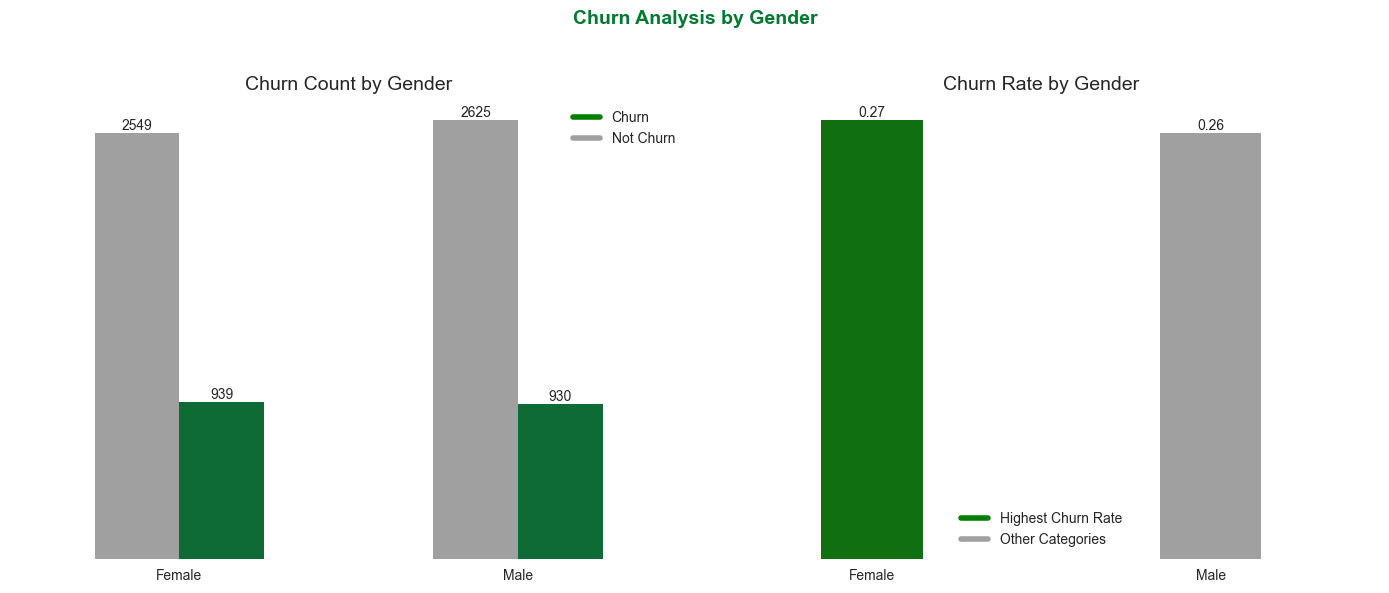

Chi-Square Statistic: 0.4841
P-Value: 0.4866
Effect size: Negligible


In [10]:
# Visualize churn distribution by the 'gender' variable
plot_bar_churn_comparison(df, var_col='gender', churn_col='Churn')

# Perform a chi-square test for the 'gender' variable
chi2_with_effect_size(df, var_col='gender', churn_col='Churn')

**Key Takeaways**

The analysis of churn by gender reveals the following details: Among female customers, there are 3,488 total customers, with 939 having churned, resulting in a churn rate of 26.9%. On the other hand, male customers total 3,555, with 930 churned, leading to a churn rate of 26.2%. The Chi-Square statistic of 0.4841 and a p-value of 0.4866 suggest that there is no statistically significant difference in churn rates between males and females. The relatively similar churn rates (26.9% for females vs 26.2% for males) further supports the conclusion that gender does not play a substantial role in determining customer churn.

#### **Q2. Are senior citizens more likely to churn compared to non-senior citizens?**

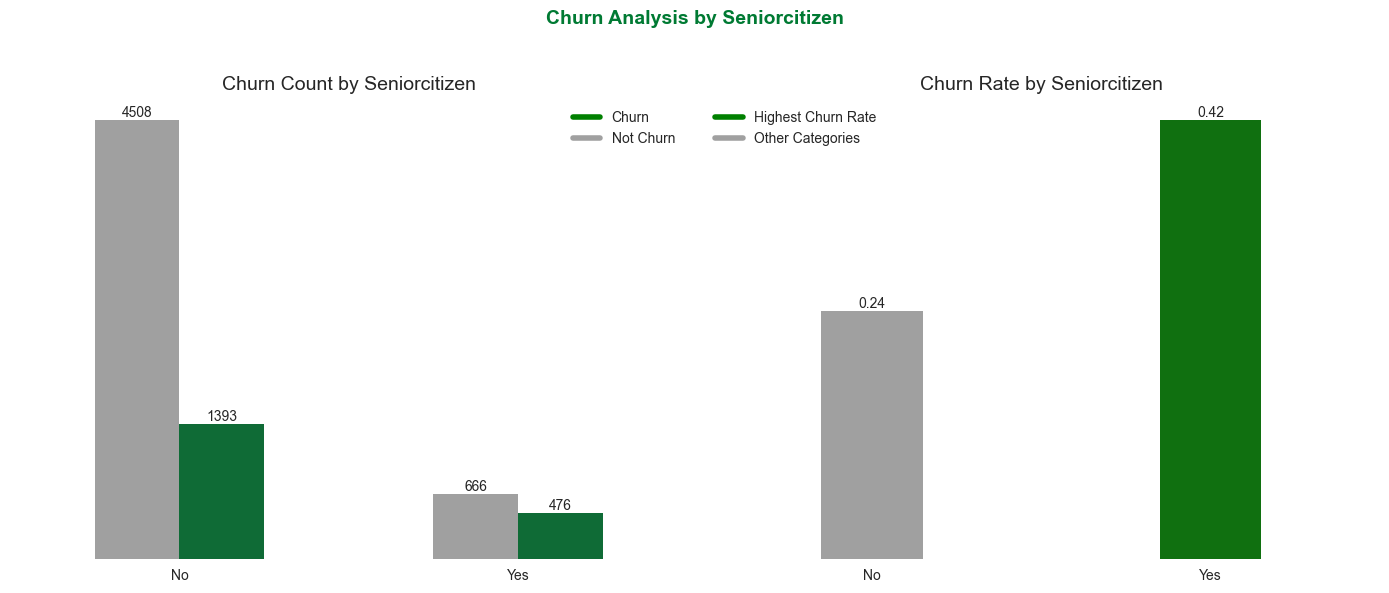

Chi-Square Statistic: 159.4263
P-Value: 0.0000
Effect size: Small


In [11]:
# Visualize churn distribution by the 'SeniorCitizen' variable
plot_bar_churn_comparison(df, var_col='SeniorCitizen', churn_col='Churn')

# Perform a chi-square test for the 'SeniorCitizen' variable
chi2_with_effect_size(df, var_col='SeniorCitizen', churn_col='Churn')

**Key Takeaways**

The analysis of churn by senior citizen status reveals notable differences between non-senior citizens and senior citizens. Among non-senior citizens, the total customer base consists of 5,901 individuals, with 1,393 customers who churned, resulting in a churn rate of 23.6%. On the other hand, senior citizens, with a total customer count of 1,142, show a significantly higher churn rate of 41.7%, with 476 customers having churned. The Chi-Square statistic of 159.4263 and a p-value of 0.0000 confirm that this difference is statistically significant, indicating that senior citizens are much more likely to churn than non-senior citizens.

#### **Q3. Does having a partner influence the customer's likelihood of churning?**

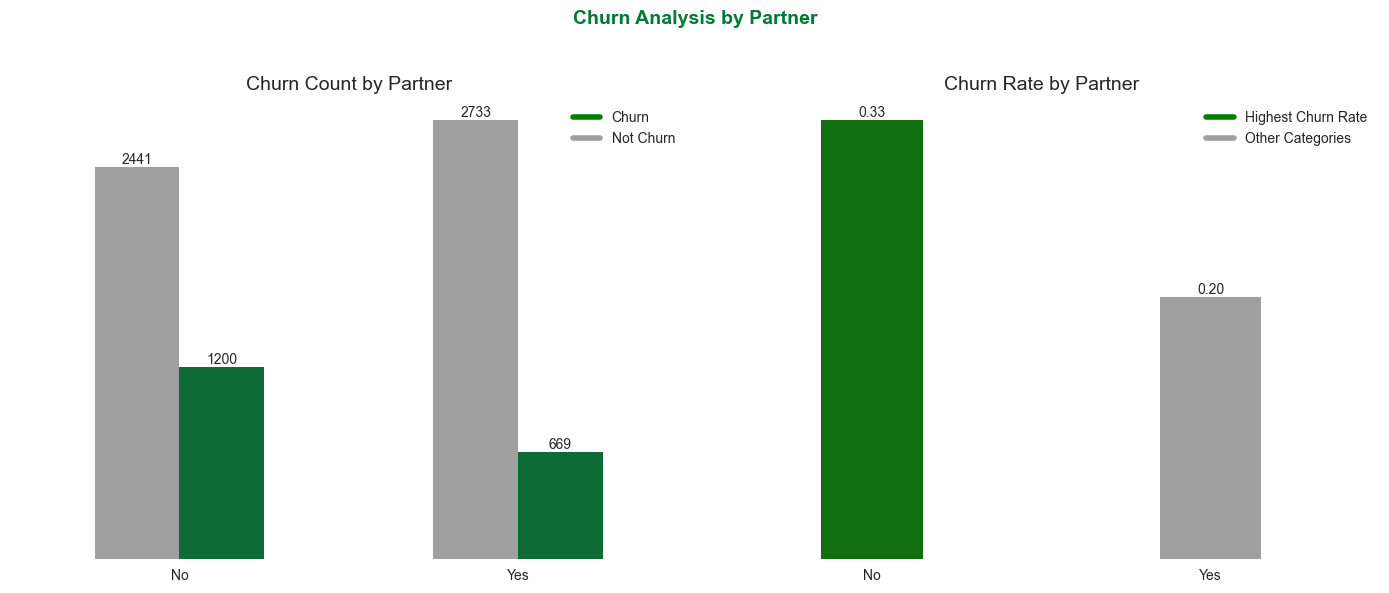

Chi-Square Statistic: 158.7334
P-Value: 0.0000
Effect size: Small


In [12]:
# Visualize churn distribution by the 'Partner' variable
plot_bar_churn_comparison(df, var_col='Partner', churn_col='Churn')

# Perform a chi-square test for the 'Partner' variable
chi2_with_effect_size(df, var_col='Partner', churn_col='Churn')


**Key Takeaways**

The analysis of churn based on partnership status reveals a significant difference between customers with and without partners. Among customers without a partner, there are 3,641 total customers, of whom 1,200 have churned, resulting in a churn rate of 33.0%. In contrast, among customers with a partner, the total number of customers is 3,402, with 669 having churned, leading to a much lower churn rate of 19.7%. The statistical test further supports the significance of this difference, as indicated by a Chi-Square statistic of 158.7334 and a p-value of 0.0000, which confirms that the relationship between partnership status and churn is statistically significant.

#### **Q4. Do customers with dependents churn at a different rate than those without?**

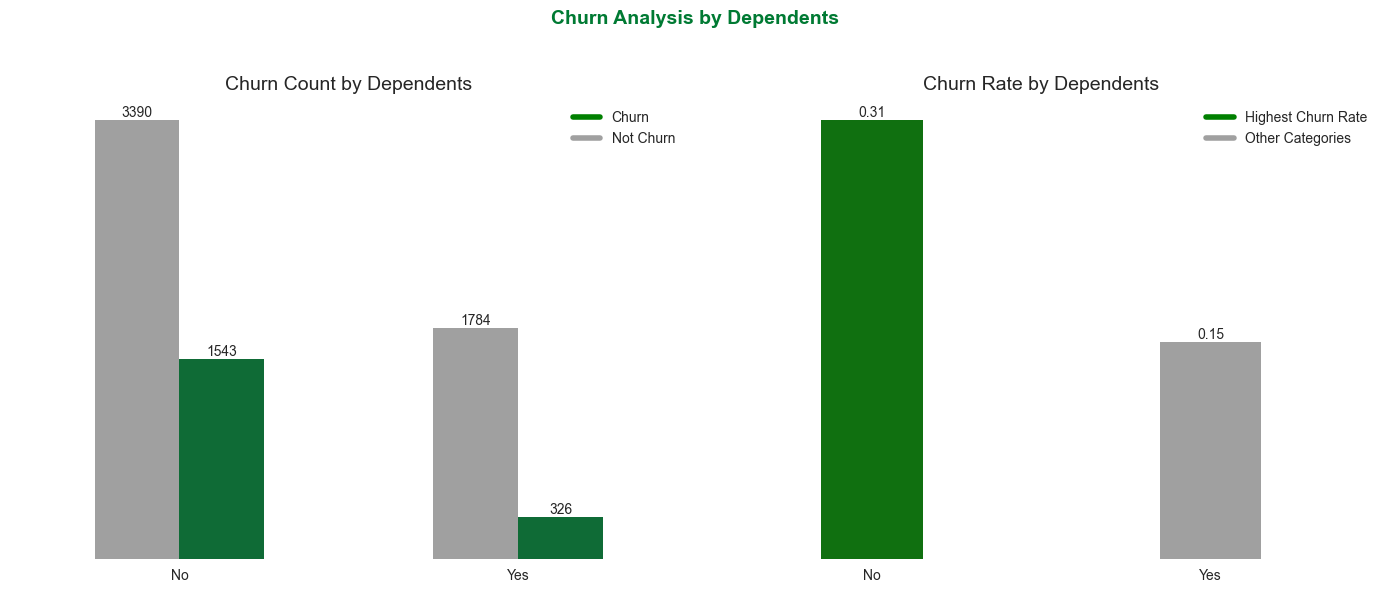

Chi-Square Statistic: 189.1292
P-Value: 0.0000
Effect size: Small


In [13]:
# Visualize churn distribution by the 'Dependents' variable
plot_bar_churn_comparison(df, var_col='Dependents', churn_col='Churn')

# Perform a chi-square test for the 'Dependents' variable
chi2_with_effect_size(df, var_col='Dependents', churn_col='Churn')

**Key Takeaways**

The analysis of customer churn based on dependency status reveals a significant difference in churn rates between non-dependents and dependents. Among non-dependents, there is a total of 4,933 customers, with 1,543 customers having churned, which translates to a churn rate of 31%. In contrast, among dependents, there are 2,110 total customers, and only 326 of them have churned, resulting in a lower churn rate of 15%. The Chi-Square test statistic of 189.1292 and a p-value of 0.0000 indicate a statistically significant relationship between dependency status and churn, meaning that the likelihood of a customer churning is strongly influenced by whether they are classified as dependents or non-dependents.

<a id="basic"></a>
### <b><span style='color:darkblue'> 3.2 What Services the Churned Customer Uses?</span></b>

Analyzing factors related to customer churn based on service usage and product subscription is essential for understanding the key drivers behind customer retention and attrition. Service usage, such as the frequency or type of services accessed by customers, provides valuable insights into customer engagement and satisfaction levels. Similarly, product subscription details, including add-ons like streaming services, internet plans, or additional phone lines, reveal patterns in customer preferences and their perceived value of the services offered. By exploring these factors, businesses can identify specific services or subscription models that contribute to higher churn rates and develop targeted strategies to enhance customer satisfaction, optimize offerings, and reduce churn effectively. This analysis not only aids in retaining existing customers but also helps in improving overall service design to meet diverse customer needs.

#### **Q1. How long has the customer been with the company?**

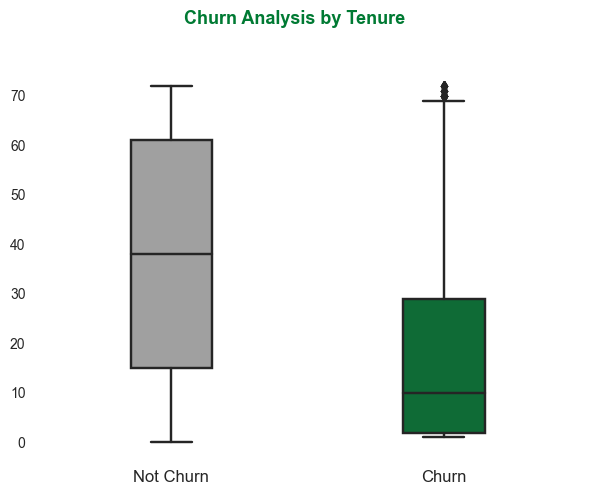

Mann-Whitney U Statistic: 2515538.0000
P-Value: 0.0000
Effect size cannot be computed.


In [14]:
# Visualize churn distribution by the 'tenure' variable
plot_boxplot_churn_comparison(df, 'tenure', 'Churn')

# Perform a mannu test for the 'tenure' variable
mannu_with_effect_size(df, 'tenure', 'Churn')

**Key Takeaways**

Customers who did not churn generally have a higher median tenure, with a wider interquartile range (IQR) spanning approximately 25 to 50 months, compared to churned customers whose tenure is clustered toward lower values, with the median below 10 months. The Mann-Whitney U test results, with p-value of 0.0000 indicate a statistically significant difference in tenure between the two groups. This suggests that longer tenure is strongly associated with reduced churn likelihood.

#### **Q2. Does having a phone service affect churn rates?**

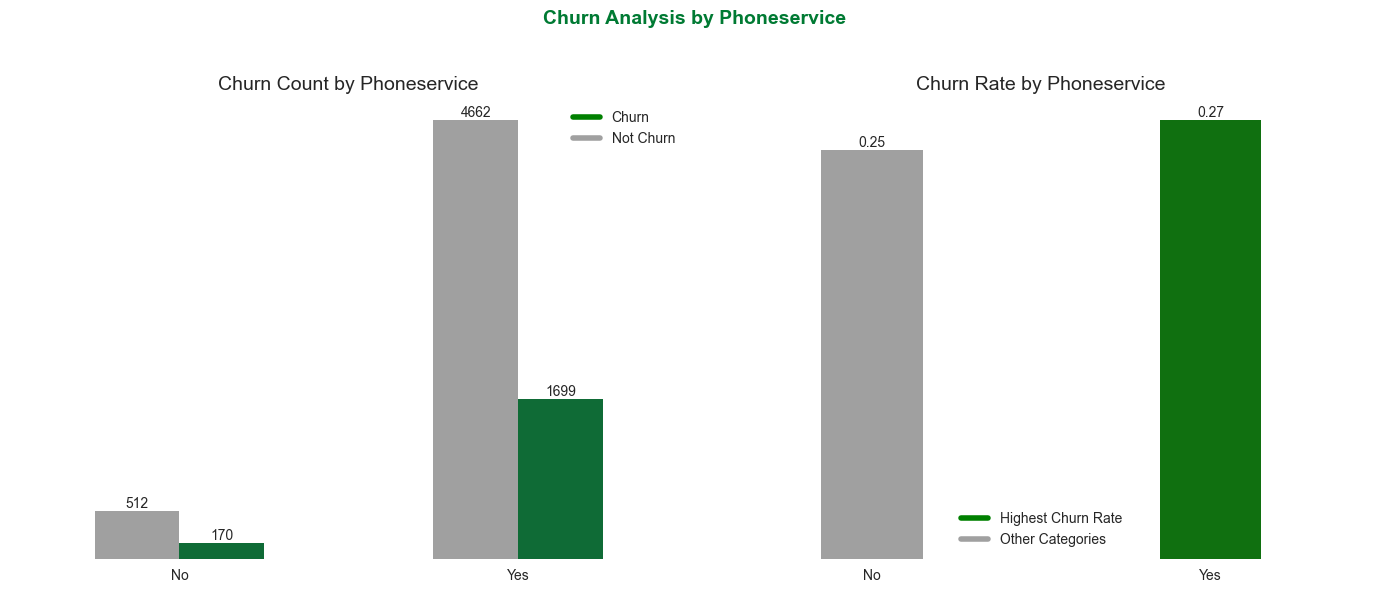

Chi-Square Statistic: 0.9150
P-Value: 0.3388
Effect size: Negligible


In [15]:
# Visualize churn distribution by the 'PhoneService' variable
plot_bar_churn_comparison(df, var_col='PhoneService', churn_col='Churn')

# Perform a chi-square test for the 'PhoneService' variable
chi2_with_effect_size(df, var_col='PhoneService', churn_col='Churn')

**Key Takeaways**

The analysis of churn based on phone service status reveals minimal differences between customers with and without phone service. Among customers without phone service, there are 682 total customers, of which 170 have churned, resulting in a churn rate of 25%. Meanwhile, for customers with phone service, the total number is significantly higher at 6,361, with 1,699 churned customers, leading to a slightly higher churn rate of 27%. Despite the small variance in churn rates, the statistical test does not support a significant relationship between phone service status and churn. The Chi-Square statistic is 0.9150, and the p-value of 0.3388 indicates no statistically significant difference in churn behavior between the two groups.

#### **Q3. Is there a difference in churn between customers with multiple phone lines vs. a single line?**

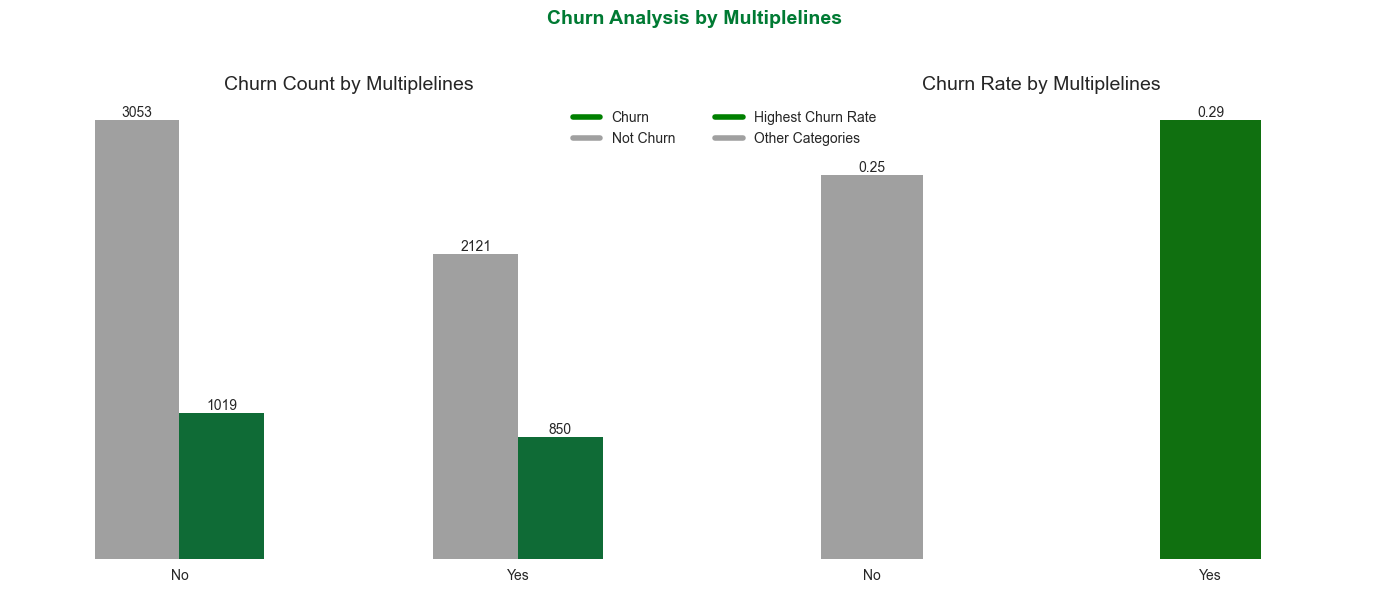

Chi-Square Statistic: 11.1433
P-Value: 0.0008
Effect size: Negligible


In [16]:
# Visualize churn distribution by the 'MultipleLines' variable
plot_bar_churn_comparison(df, var_col='MultipleLines', churn_col='Churn')

# Perform a chi-square test for the 'MultipleLines' variable
chi2_with_effect_size(df, var_col='MultipleLines', churn_col='Churn')

**Key Takeaways**

The analysis examines the relationship between having multiple phone lines and customer churn. Among customers without multiple phone lines, there are 3,053 who did not churn and 1,019 who did, resulting in a churn rate of 25%. For customers with multiple phone lines, 2,121 did not churn while 850 churned, yielding a higher churn rate of 29%. The chi-square test produces a statistic of 11.1433 with a p-value of 0.0008, indicating that the relationship between having multiple phone lines and churn is statistically significant. This suggests that customers with multiple phone lines are more likely to churn compared to those without, warranting further investigation into the reasons behind this trend.

#### **Q4. Does the type of internet service (DSL, Fiber, No service) influence churn?**

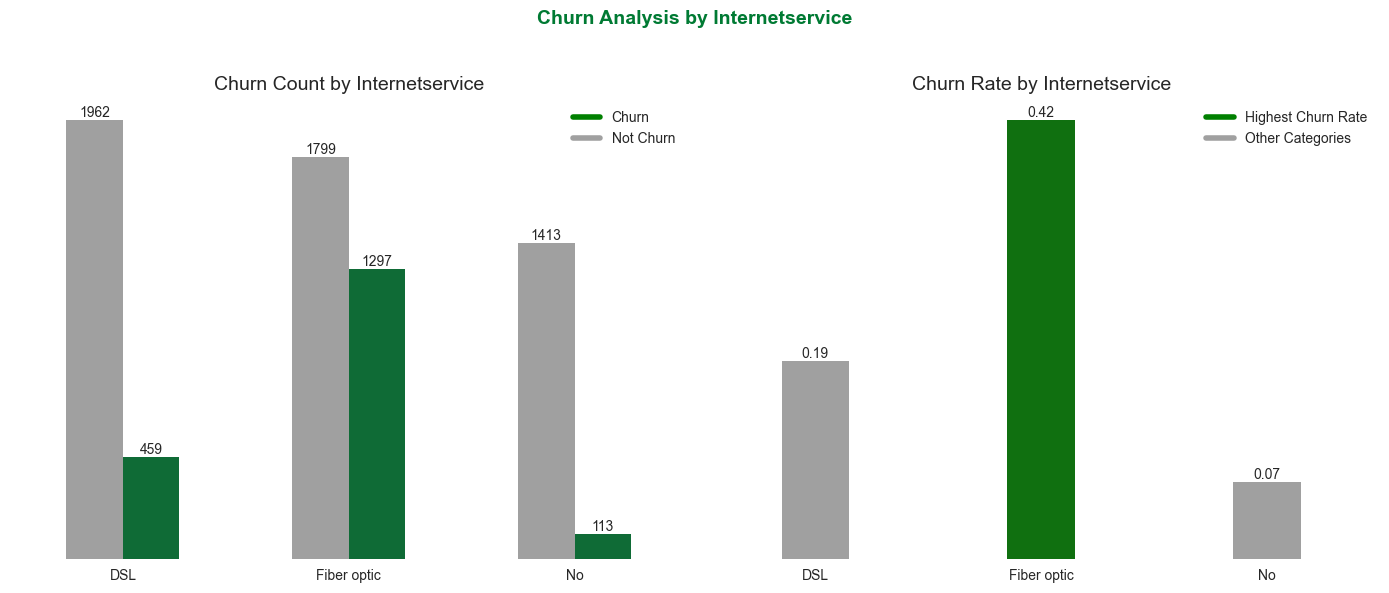

Chi-Square Statistic: 732.3096
P-Value: 0.0000
Effect size: Medium


In [17]:
# Visualize churn distribution by the 'InternetService' variable
plot_bar_churn_comparison(df, var_col='InternetService', churn_col='Churn')

# Perform a chi-square test for the 'InternetService' variable
chi2_with_effect_size(df, var_col='InternetService', churn_col='Churn')

**Key Takeaways**

The analysis of churn based on internet service type reveals significant disparities in churn rates among different customer groups. Customers with DSL internet service exhibit a churn rate of 19%, with 459 churned customers out of a total of 2,421. In contrast, customers with fiber optic internet service show a much higher churn rate of 42%, with 1,297 churned customers out of 3,096. On the other hand, customers without internet service experience the lowest churn rate at just 7%, with 113 churned customers out of 1,526. 
The Chi-Square test yields a statistic of 732.3096 and a p-value of 0.0000, indicating a highly significant relationship between the type of internet service and customer churn. This result underscores the substantial impact that internet service type has on churn behavior.

#### **Q5. Do customers who subscribe to value-added services experience fewer churn than those who do not?**

In [18]:
# list columns to analyze
columns_to_analyze = ['OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# dataFrame to store the results
results = pd.DataFrame()

for col in columns_to_analyze:
    # generate a crosstab
    contingency_table = pd.crosstab(df[col], df['Churn'])
    contingency_table.rename_axis(columns={'Churn': ''}, inplace=True)
    
    # perform the chi-square test
    chi2, p, dof, expected = stat.chi2_contingency(contingency_table)

    # perform the Cramér's V
    n = contingency_table.sum().sum()  # Jumlah total observasi
    cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
    
    # add results to the DataFrame
    contingency_table['Total'] = contingency_table.sum(axis=1)  # add the total count
    contingency_table['Churn Rate (%)'] = (contingency_table['Yes'] / contingency_table['Total'] * 100).round(2)  # calculate and add churn rate
    contingency_table['Chi2 Stats'] = np.round(chi2, 5)  # add the chi2 value
    contingency_table['P-value'] = np.round(p, 5)  # add the p-value
    contingency_table['Effect Size'] = cramers_v  # add the effect size
    contingency_table['Services'] = col  # add the feature name
    
    # apply a multi-index for combined results
    contingency_table = contingency_table.reset_index().set_index(['Services', col])
    results = pd.concat([results, contingency_table])

# display the results
results.drop(columns='Total', inplace=True)
results.rename_axis(index={'OnlineSecurity': ''}, inplace=True)
results.rename(columns={'No': 'Not Churn', 'Yes': 'Churn'}, inplace=True)
results.round(2)

Not Churn  Churn  Churn Rate (%)  Chi2 Stats  P-value  \
Services                                                                      
OnlineSecurity   No        3450   1574           31.33      205.63      0.0   
                 Yes       1724    295           14.61      205.63      0.0   
OnlineBackup     No        3268   1346           29.17       47.26      0.0   
                 Yes       1906    523           21.53       47.26      0.0   
DeviceProtection No        3297   1324           28.65       30.51      0.0   
                 Yes       1877    545           22.50       30.51      0.0   
TechSupport      No        3440   1559           31.19      190.17      0.0   
                 Yes       1734    310           15.17      190.17      0.0   
StreamingTV      No        3281   1055           24.33       27.86      0.0   
                 Yes       1893    814           30.07       27.86      0.0   
StreamingMovies  No        3260   1051           24.38       26.25      0.0   
                 Yes       1914    818           29.94       26.25      0.0   

                      Effect Size  
Services                           
OnlineSecurity   No          0.17  
                 Yes         0.17  
OnlineBackup     No          0.08  
                 Yes         0.08  
DeviceProtection No          0.07  
                 Yes         0.07  
TechSupport      No          0.16  
                 Yes         0.16  
StreamingTV      No          0.06  
                 Yes         0.06  
StreamingMovies  No          0.06  
                 Yes         0.06

**Key Takeaways**

The table presents an analysis of customer churn based on their subscription to various services. Services like OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport show a clear association with lower churn rates, suggesting they play a role in retaining customers. In contrast, StreamingTV and StreamingMovies are linked to higher churn rates, indicating they might not be as effective in preventing churn. The statistically significant chi-square results across all services (p-value = 0.0000) reinforce the validity of these findings. Businesses should consider focusing on promoting essential security and support services to reduce churn while reevaluating the impact of entertainment-related services.

<a id="basic"></a>
### <b><span style='color:darkblue'> 3.3 How the Churned Customer Pays?</span></b>

Understanding the factors influencing customer churn is critical for businesses aiming to improve retention rates and maintain sustainable growth. Among the key factors, the type of contract and billing method play a significant role in determining a customer's likelihood to churn. Contract type—whether it is month-to-month, one-year, or two-year—directly impacts the commitment level of customers, with shorter contracts often associated with higher churn rates due to their flexibility. Similarly, billing methods, such as electronic billing versus mailed invoices, may influence customer satisfaction and ease of payment, which can indirectly affect retention. This analysis focuses on evaluating the relationship between these variables and churn behavior, aiming to uncover actionable insights that can guide strategies for improving customer loyalty and reducing churn. By identifying patterns and statistical significance, businesses can better tailor their offerings to meet customer needs and preferences.

#### **Q1. Do customers on month-to-month contracts churn more than those on one- or two-year contracts?**

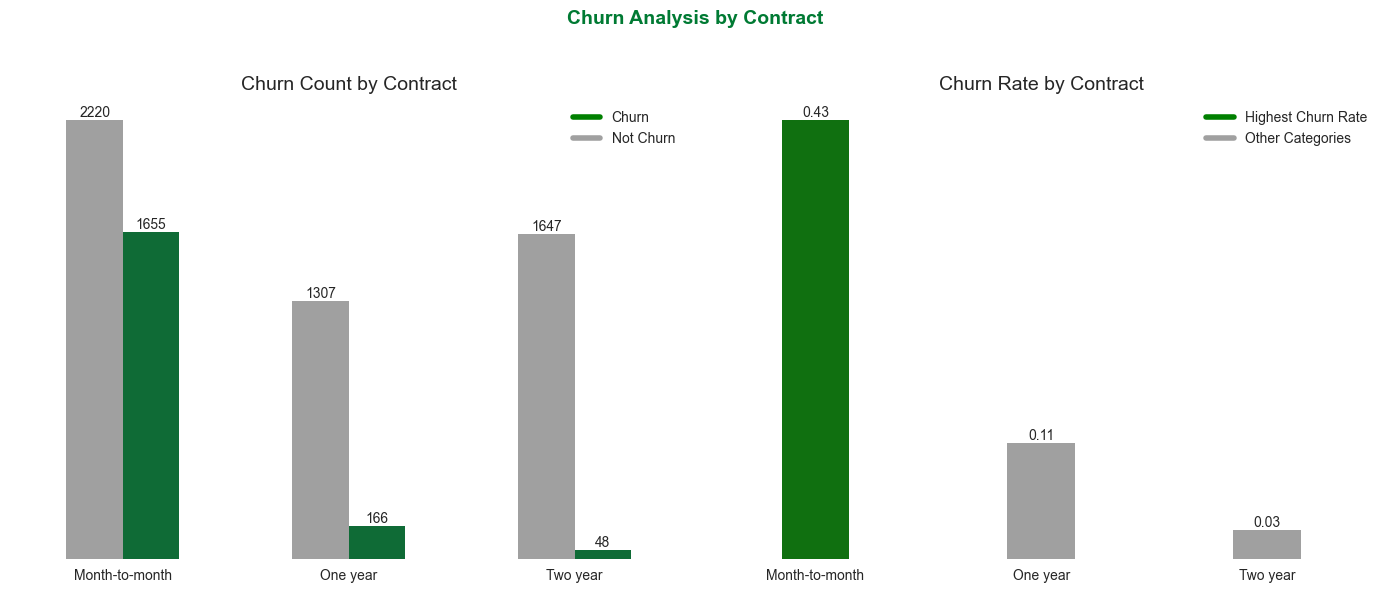

Chi-Square Statistic: 1184.5966
P-Value: 0.0000
Effect size: Medium


In [19]:
# Visualize churn distribution by the 'Contract' variable
plot_bar_churn_comparison(df, var_col='Contract', churn_col='Churn')

# Perform a chi-square test for the 'Contract' variable
chi2_with_effect_size(df, var_col='Contract', churn_col='Churn')

**Key Takeaways**

The analysis of customer churn rates across different contract types reveals a clear and significant relationship between the type of contract and the likelihood of churn. Customers with month-to-month contracts exhibit the highest churn rate at 43%, with 1,655 out of 3,875 customers discontinuing the service. This group, characterized by its flexibility and lack of long-term commitment, appears to be the most vulnerable to churn. In contrast, customers with one-year contracts have a significantly lower churn rate of 11%, with only 166 out of 1,473 customers leaving. The lowest churn rate, at 3%, is observed among customers with two-year contracts, where only 48 out of 1,695 customers discontinue the service. The Chi-Square Statistic of 1,184.5966 and a p-value of 0.0000 confirm that the relationship between contract type and churn is statistically significant. This finding suggests that customers on longer-term contracts are far less likely to churn, likely due to stronger commitment and potential benefits such as discounted rates or additional perks.

#### **Q2. Does opting for paperless billing impact churn rates?**

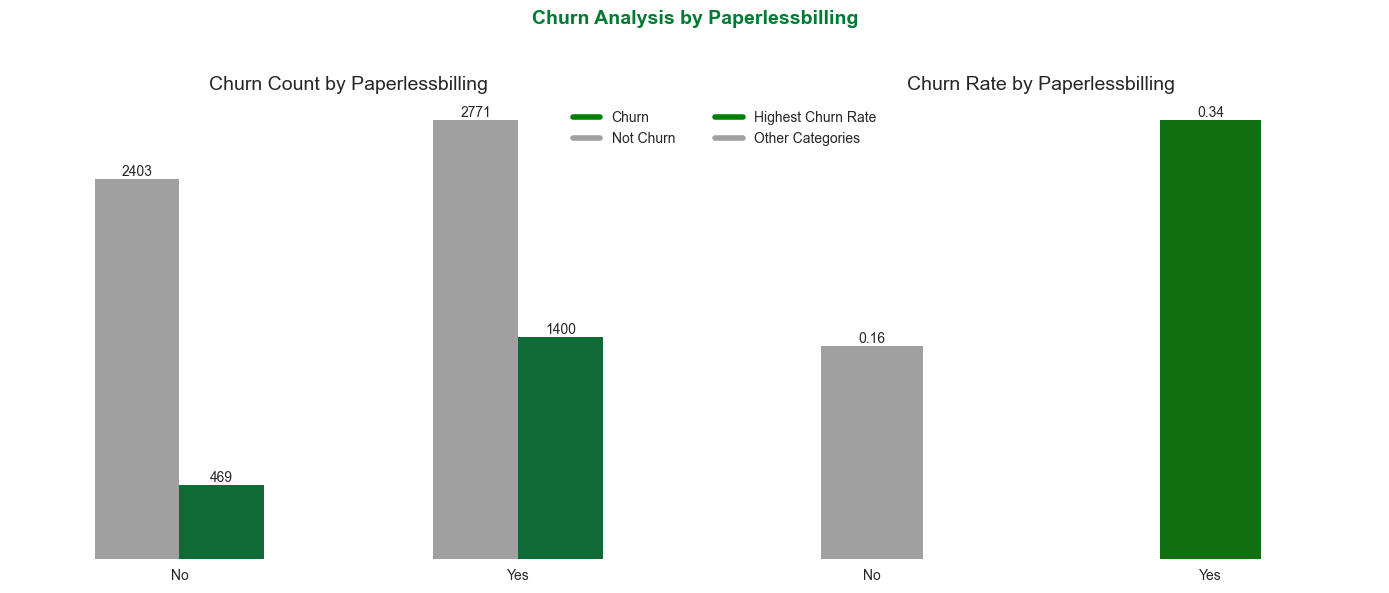

Chi-Square Statistic: 258.2776
P-Value: 0.0000
Effect size: Small


In [20]:
# Visualize churn distribution by the 'PaperlessBilling' variable
plot_bar_churn_comparison(df, var_col='PaperlessBilling', churn_col='Churn')

# Perform a chi-square test for the 'PaperlessBilling' variable
chi2_with_effect_size(df, var_col='PaperlessBilling', churn_col='Churn')

**Key Takeaways**

The analysis of churn rates based on the adoption of paperless billing reveals a significant difference in customer behavior. Customers who do not use paperless billing exhibit a relatively low churn rate of 16%, with 469 out of 2,872 customers leaving the service. In contrast, customers who have opted for paperless billing demonstrate a much higher churn rate of 34%, with 1,400 out of 4,171 customers discontinuing their subscription. The chi-square test statistic of 258.2776 and a p-value of 0.0000 indicate that the relationship between paperless billing and churn is statistically significant. This highlights a strong association between the choice of billing method and the likelihood of customer churn.

#### **Q3. Do customers with certain payment methods (e.g., electronic check vs. credit card) churn more frequently?**

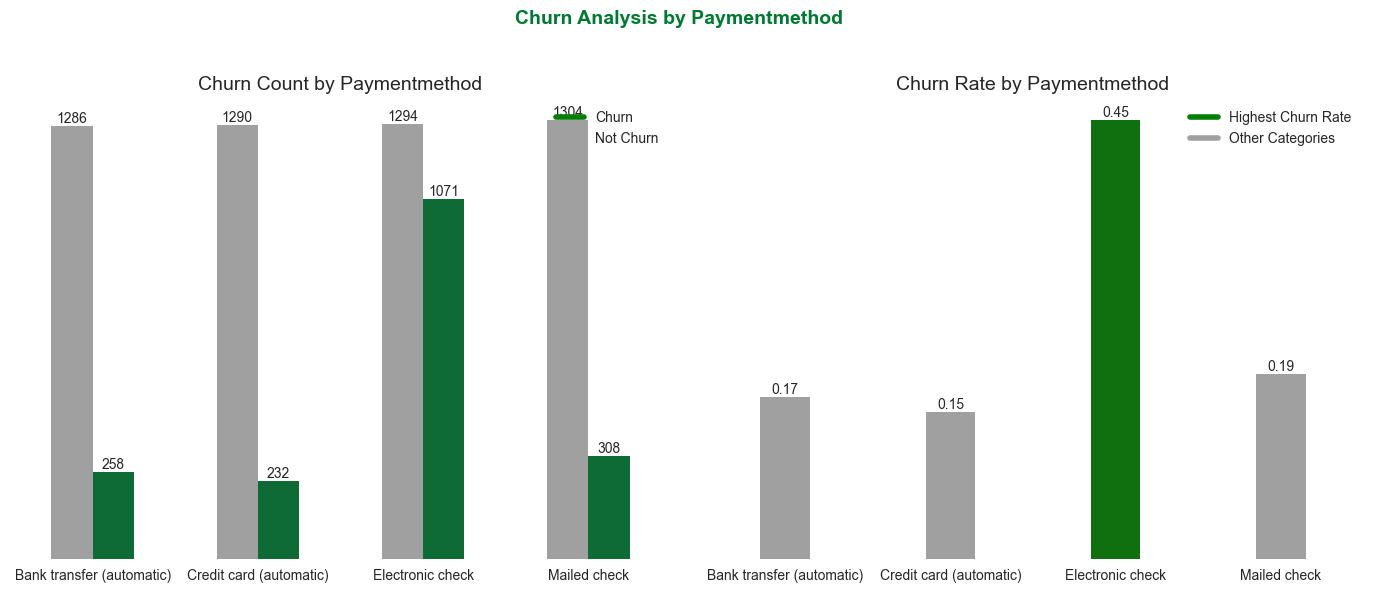

Chi-Square Statistic: 648.1423
P-Value: 0.0000
Effect size: Medium


In [21]:
# Visualize churn distribution by the 'PaymentMethod' variable
plot_bar_churn_comparison(df, var_col='PaymentMethod', churn_col='Churn')

# Perform a chi-square test for the 'PaymentMethod' variable
chi2_with_effect_size(df, var_col='PaymentMethod', churn_col='Churn')

**Key Takeaways**

The analysis of churn rates based on different payment methods reveals significant disparities that highlight their impact on customer retention. Among customers using bank transfer (automatic), 258 out of 1,544 have churned, resulting in a churn rate of 17%, while those utilizing credit card (automatic) have an even lower churn rate of 15%, with 232 out of 1,522 customers leaving. In contrast, electronic check users experience the highest churn rate at a staggering 45%, with 1,071 out of 2,365 customers discontinuing their service. Meanwhile, customers paying via mailed check have a churn rate of 19%, with 308 out of 1,612 leaving the service. The chi-square test statistic of 648.1423 and an extremely low p-value of 0.0000 indicate that the relationship between payment methods and churn is statistically significant. This suggests that the type of payment method is strongly associated with a customer's likelihood of churn.

#### **Q4. How do monthly charges and the total amount spent by customers influence their likelihood of churn?**

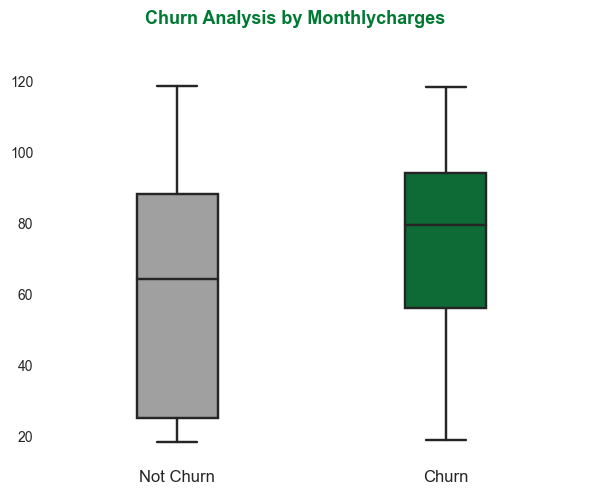

Mann-Whitney U Statistic: 6003125.5000
P-Value: 0.0000
Effect size cannot be computed.


In [22]:
# Visualize churn distribution by the 'MonthlyCharges' variable
plot_boxplot_churn_comparison(df, 'MonthlyCharges', 'Churn')  

# Perform a mannu test for the 'MonthlyCharges' variable
mannu_with_effect_size(df, 'MonthlyCharges', 'Churn')

**Key Takeaways**

The median monthly charges for customers who churn are visibly higher compared to those who do not churn, indicating that customers paying more per month are more likely to leave. With p-value of 0.0000 from the Mann-Whitney U test confirm that the difference in distributions is statistically significant. This suggests that higher monthly charges may be a key driver of churn, potentially due to dissatisfaction with pricing or perceived lack of value for the cost.

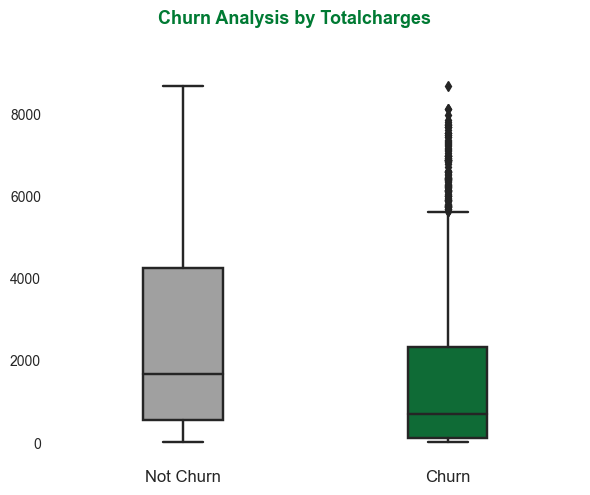

Mann-Whitney U Statistic: 3380795.0000
P-Value: 0.0000
Effect size cannot be computed.


In [23]:
# Visualize churn distribution by the 'TotalCharges' variable
plot_boxplot_churn_comparison(df, 'TotalCharges', 'Churn')  

# Perform a mannu test for the 'TotalCharges' variable
mannu_with_effect_size(df, 'TotalCharges', 'Churn')

**Key Takeaways**

Customers who churn generally have lower total charges compared to those who remain, as indicated by the lower median and narrower range for the churn group. The Mann-Whitney U test result with p-value of 0.0000 confirms that the difference between the distributions is statistically significant. This trend suggests that customers with shorter tenures, and therefore lower total charges, are more likely to churn. 

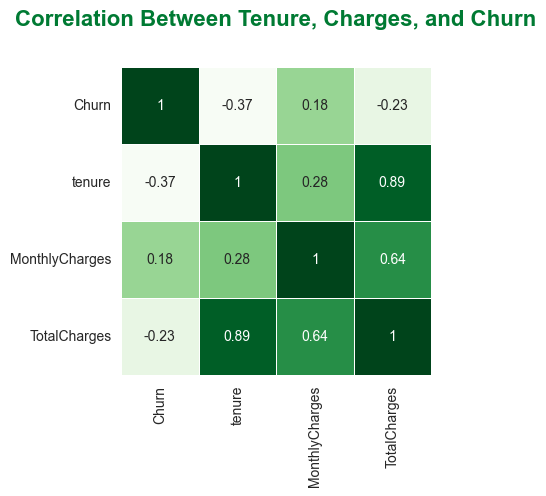

In [24]:
# define a list of columns to analyze for correlation
cols_to_plot = ['Churn', 'tenure', 'MonthlyCharges', 'TotalCharges']

# set the figure size
plt.figure(figsize=(4, 4))

# calculate the Spearman correlation matrix
correlation_matrix = df[cols_to_plot].replace(to_replace={'Yes':1, 'No':0}).corr(numeric_only=True, method='spearman').round(2)

# create a heatmap to visualize
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', linewidths=0.5, cbar=False)
plt.title('Correlation Between Tenure, Charges, and Churn', loc='center', fontsize=16, fontweight='bold', color='#007A33', pad=30)

# show
plt.show()

**Key Takeaways**
- The heatmap presents the Spearman correlation coefficients between customer churn and purchasing behavior variables, including tenure, MonthlyCharges, and TotalCharges. The variable tenure shows a negative correlation with churn (-0.37), suggesting that customers with longer tenures are less likely to churn, indicating that loyalty and sustained engagement reduce the likelihood of leaving. Conversely, MonthlyCharges exhibits a weak positive correlation with churn (0.18), implying that customers paying higher recurring fees are slightly more prone to churn, potentially due to cost sensitivity. For TotalCharges, the correlation with churn is also negative (-0.23), consistent with the notion that customers with higher cumulative spending—often a byproduct of longer tenure—are less likely to churn. 
- Strong positive correlations between tenure and TotalCharges (0.89), and between MonthlyCharges and TotalCharges (0.64), underline the interconnectedness of these variables, as longer-tenured customers typically accumulate higher total charges and higher monthly charges contribute to larger overall spending. These insights suggest that tenure and cumulative spending are critical factors for retention, while monthly charges might need to be optimized to reduce churn risk.

<a id="basic"></a>
### <b><span style='color:darkblue'> 3.4 What Drives Customer Loyalty?</span></b>

Traditional analyses, as outlined in Sections 3.1 to 3.3, typically focus on individual factors influencing customer churn. In contrast, Cross-Category Analysis offers a more comprehensive perspective by examining the interactions and relationships between variables across multiple categories. This approach explores how dimensions such as demographics, service subscriptions, and billing behaviors interact to influence churn. By uncovering these cross-dimensional insights, it becomes possible to identify hidden patterns and interdependencies that remain obscured in univariate or bivariate analyses.

#### **Q1. How does tenure interact with contract type and monthly charges to impact churn?**

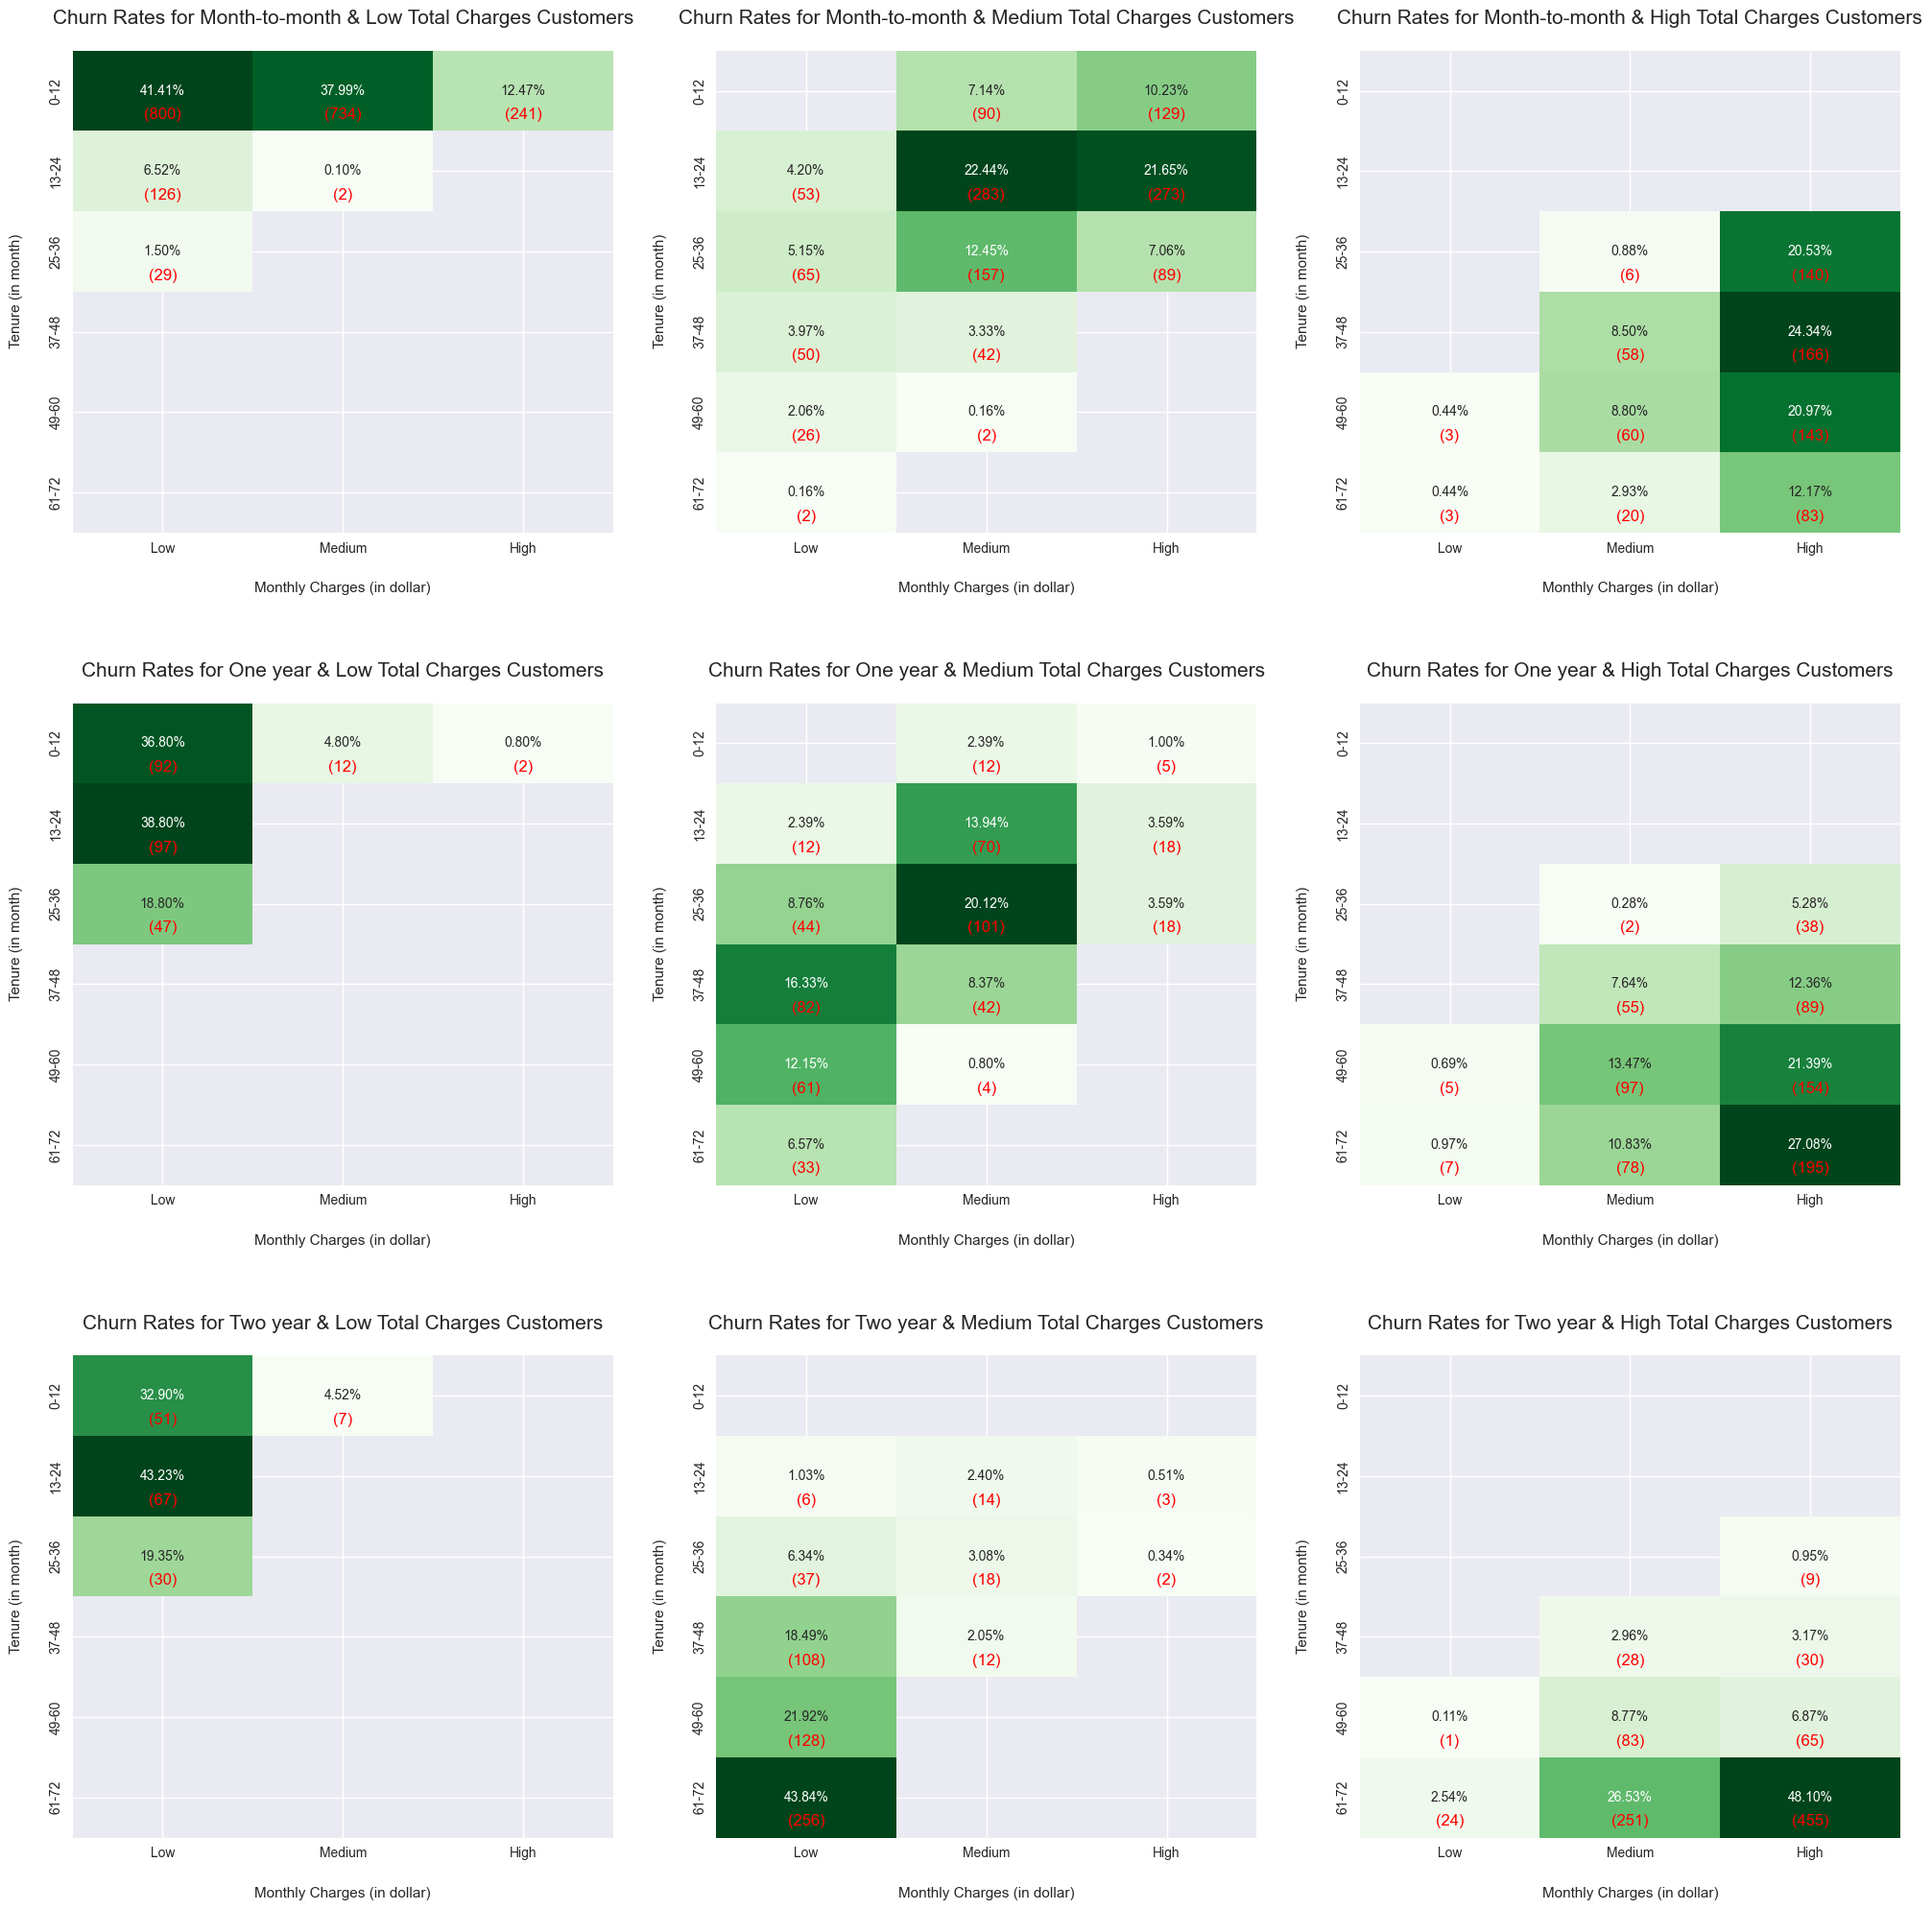

In [25]:
# Calculate churn rates for each group (contract type, total charges category, tenure bin, monthly bin)
churn_rate = df.groupby(['Contract', 'TotalChargesCategory', 'TenureCategory', 'MonthlyChargesCategory', 'Churn']).size().reset_index(name='Count')

# Create a heatmap for each contract type and total charges category
fig, axes = plt.subplots(3, 3, figsize=(20, 20), sharey=False)

# Loop through contract types and total charge categories
for i, contract in enumerate(['Month-to-month', 'One year', 'Two year']):
    for j, category in enumerate(['Low', 'Medium', 'High']):
        ax = axes[i, j]

        # Filter data for the specific contract and total charges category
        subset = churn_rate[(churn_rate['Contract'] == contract) & 
                            (churn_rate['TotalChargesCategory'] == category)]

        # Pivot the data to get churn counts across tenure and monthly charges
        pivot_data = subset.pivot_table(index='TenureCategory', columns='MonthlyChargesCategory', 
                                        values='Count', aggfunc='sum')

        # Normalize the churn rate (Churn = 'Yes') within each cell
        pivot_data_normalized = pivot_data.div(pivot_data.sum().sum())

        # Mask zero values by replacing them with NaN
        masked_data = pivot_data_normalized.replace(0, np.nan)

        # Plot heatmap
        sns.heatmap(masked_data, annot=True, fmt='.2%', cmap='Greens', cbar=False, ax=ax, linewidths=0)

        # Annotate the churn counts below the churn rate values
        for y in range(masked_data.shape[0]):
            for x in range(masked_data.shape[1]):
                count_value = pivot_data.loc[pivot_data.index[y], pivot_data.columns[x]]
                
                # Annotate only if churn count is greater than 0
                if count_value > 0.00000:
                    ax.text(
                        x + 0.5, y + 0.8, f'({count_value})',  # Count annotation
                        ha='center', va='center', color='red', fontsize=12
                    )
        # Set the title of the plot, with the contract and category included in the title
        ax.set_title(f'Churn Rates for {contract} & {category} Total Charges Customers', fontsize=15, pad=20)

        # Set the label for the x-axis and y-axis
        ax.set_xlabel('Monthly Charges (in dollar)', labelpad=20)
        ax.set_ylabel('Tenure (in month)', labelpad=20)

# Adjust the layout of the plots to ensure there is enough space for labels and titles
plt.tight_layout(h_pad=5, w_pad=3)

# Display the plot
plt.show()

**Key Takeaways**

Based on the heatmap you have provided, it seems to be an analysis of churn rates across different customer groups, categorized by two key factors: `Monthly Charges` and `Total Charges`. Each panel of the heatmap represents the churn rate (percentage value) and churn count (shown in red) for specific customer segments based on their `Contract` type and `tenure`. Here's a detailed analysis:

- **Month-to-Month Customers:** These customers are the highest churn risk group overall, particularly those paying higher monthly charges and short-to-medium tenure customers. This indicates that month-to-month plans, while flexible, tend to result in less commitment. Higher monthly charges seem to correlate with a higher churn probability, which is concerning for this group.

    - Low Total Charge: Month-to-month customers with Low Total Charges have high churn in the beginning (0-12 months tenure). Churn decreases dramatically with increasing tenure, especially if monthly charges are low or medium.
    - Medium Total Charge: Short to Medium Tenure (13-36 months) is the area with the highest churn, especially with Medium and High monthly charges. Retention improves as tenure increases, but dissatisfaction among medium-tenure customers with higher monthly charges is a concern.
    - High Total Charge: Customers with High Total Charges at High Monthly Charges have the highest churn at 25-60 months tenure. In contrast, Low Monthly Charges are able to keep churn low across all tenures.

- **One-Year Contract Customers:** Churn rates are generally lower compared to month-to-month customers, with the exception of high total charges and high monthly charges, where churn rates increase.

    - Low Total Charge: Customers with short contracts at the beginning (low monthly charges) are more likely to churn. However, as tenure increases, churn decreases significantly.
    - Medium Total Charge: In medium total charge customers, churn is high in medium tenure (25-36 months) and slightly reduced in long tenure. Customers with low monthly charges are more prone to churn than high charges customers.
    - High Total Charge: High total charges customers with long tenure have the highest churn rate, especially when monthly charges are high. Conversely, low charges can reduce churn despite long tenures.

- **Two-Year Contract Customers:** Customers with high monthly charges and longer tenures tend to have the lowest churn rate, and short-tenure customers with low total charges represent the highest risk for churn.

    - Low Total Charge: Customers with Low Total Charges tend to churn early (13-24 months), perhaps because the value of the product/service does not meet expectations in this short period. Longer tenure (>36 months) shows a significant decrease in churn, possibly due to increased customer loyalty.
    - Medium Total Charge: Customers with Medium Total Charges tend to be stable in the early and middle tenures. However, churn increases significantly at the end of the period (>61 months), possibly because customers are looking for alternative services or feel they are no longer getting value for money.
    - High Total Charge: Customers with High Total Charges tend to stay in the short-medium term. However, churn increases sharply at long tenure (61-72 months), possibly due to high monthly charges that are no longer commensurate with customer satisfaction.

Monthly charges play a significant role in customer churn, with higher charges strongly correlating to increased churn rates across all contract types and tenure levels. Customers with short tenures, particularly those on month-to-month contracts, exhibit the highest volatility and are most prone to churn. On the other hand, long-tenure customers in one-year and two-year contracts experience higher churn rates when faced with increased monthly charges. Additionally, the type of contract matters, as month-to-month plans are the most vulnerable to churn, while two-year contracts demonstrate the highest stability.

#### **Q2. How does the bundling of InternetService, PhoneService, and additional services relate to churn behavior?**

In [26]:
# Group the data by the service bundle and churn status, then calculate the size of each group
churn_summary = df.groupby(['ServiceBundle', 'Churn']).size().unstack(fill_value=0)

# Add a column that calculates the total number of customers in each service bundle category
churn_summary['Total'] = churn_summary.sum(axis=1)

# Calculate the churn rate as the percentage of 'Yes' churns over the total customers
churn_summary['Churn Rate (%)'] = ((churn_summary['Yes'] / churn_summary['Total']) * 100).round(2)

# Sort the summary table by churn rate in descending order
churn_summary = churn_summary.sort_values(by="Churn Rate (%)", ascending=False)

# Display the table
display(churn_summary)

Churn,No,Yes,Total,Churn Rate (%)
ServiceBundle,,,,
Fiber optic_Internet + 0 Add-ons,158,241,399,60.40
Fiber optic_Internet + 1 Add-ons,243,308,551,55.90
Fiber optic_Internet + 2 Add-ons,301,278,579,48.01
DSL_Internet + 0 Add-ons,128,86,214,40.19
Fiber optic_Internet + 3 Add-ons,399,244,643,37.95
Fiber optic_Internet + 4 Add-ons,336,157,493,31.85
DSL_Internet + 1 Add-ons,215,86,301,28.57
DSL_Internet Only,512,170,682,24.93
Fiber optic_Internet + 5 Add-ons,234,56,290,19.31


**Key Takeaways**

The provided table analyzes how the bundling of InternetService, PhoneService, and additional services relates to customer churn. Let's break down the findings based on the `ServiceBundle`, `Churn Rate (%)`, and overall churn behavior.

- **Fiber optic vs. DSL Bundles:** Bundling InternetService (Fiber optic or DSL) with additional services (such as tech support, streaming services, etc.) generally reduces churn.
   - Fiber optic bundles with internet and varying numbers of add-ons (from 0 to 6) generally have higher churn rates compared to DSL bundles.
   - The highest churn rate (60.4%) occurs with Fiber optic_Internet + 0 Add-ons, while DSL_Internet + 6 Add-ons has the lowest churn rate (1.69%).
   - In general, Fiber optic bundles tend to have higher churn rates than DSL bundles, regardless of the number of add-ons.

- **Effect of Add-ons:** Customers who opt for more add-ons are less likely to churn, especially when they choose Fiber optic internet bundles.
   - Fiber optic bundles with more than 2 add-ons (Fiber optic_Internet + 3 Add-ons, Fiber optic_Internet + 4 Add-ons, etc.) show a decreasing trend in churn rates. For instance:
     - Fiber optic_Internet + 4 Add-ons has a churn rate of 31.85%, while Fiber optic_Internet + 0 Add-ons has the highest churn rate at 60.4%. This suggests that as customers add more services to their bundle, their likelihood of churn decreases.
   - DSL bundles particularly those with 3 or more add-ons, show similar trends: DSL_Internet + 5 Add-ons and DSL_Internet + 6 Add-ons have very low churn rates (4.76% and 1.69%, respectively).

- **Internet Only vs. Phone Only:** Customers who are not combining services with internet are more stable.
   - DSL_Internet Only shows a churn rate of 24.93%, which is lower than most Fiber optic bundles with fewer add-ons but higher than the bundles with more add-ons.
   - Phone Only service has a very low churn rate of 7.40%, indicating that customers with just phone service are less likely to churn compared to those who bundle internet and additional services.
   
- **Churn and Service Bundle Variety:** The more services bundled together, the lower the churn rate.
   - There is a clear trend that bundling Fiber optic internet with a higher number of add-ons (3 or more) reduces the churn rate. For example:
     - Fiber optic_Internet + 3 Add-ons: Churn rate = 37.95%
     - Fiber optic_Internet + 4 Add-ons: Churn rate = 31.85%
     - Fiber optic_Internet + 5 Add-ons: Churn rate = 19.31%
     - Fiber optic_Internet + 6 Add-ons: Churn rate = 9.22%
   - In contrast, customers with only DSL internet or Phone Only services tend to have lower churn rates, but the addition of more services typically leads to an increase in retention.

In summary, bundling services, especially with Fiber optic internet and a greater number of add-ons, significantly impacts churn rates. Customers who choose simpler bundles or phone-only services are more likely to churn, while customers opting for larger service bundles tend to stay longer, especially when internet service is involved.

#### **Q3. What role does the combination of tenure, contract type, and service add-ons play in churn reduction?**

In [27]:
# Analyze bundling within tenure-contract groups
combine_churn = df.groupby(['TenureCategory', 'Contract', 'TotalChargesCategory', 'ServiceBundle', 'Churn']).size().unstack()

# Add a column that calculates the total number of customers in each service bundle category
combine_churn['Total'] = combine_churn.sum(axis=1)

# Calculate the churn rate as the percentage of 'Yes' churns over the total customers
combine_churn['Churn Rate (%)'] = ((combine_churn['Yes'] / combine_churn['Total']) * 100).round(2)

# Filter the table by churn rate in descending order
combine_churn = combine_churn[
    (combine_churn['Total'] > 20) & 
    (combine_churn['Churn Rate (%)'] != 0) &
    (combine_churn['Churn Rate (%)'] >= 21)
    ].dropna()

# Display the table
display(combine_churn)

Churn                                                                                 No  \
TenureCategory Contract       TotalChargesCategory ServiceBundle                           
0-12           Month-to-month Low                  DSL_Internet + 0 Add-ons           88   
                                                   DSL_Internet + 1 Add-ons           99   
                                                   DSL_Internet + 2 Add-ons           58   
                                                   DSL_Internet + 3 Add-ons           34   
                                                   DSL_Internet Only                  92   
                                                   Fiber optic_Internet + 0 Add-ons   77   
                                                   Fiber optic_Internet + 1 Add-ons   61   
                                                   Fiber optic_Internet + 2 Add-ons   38   
                                                   Fiber optic_Internet + 3 Add-ons   17   
                                                   Phone Only                        300   
                              Medium               Fiber optic_Internet + 0 Add-ons   12   
                                                   Fiber optic_Internet + 1 Add-ons   26   
                                                   Fiber optic_Internet + 2 Add-ons   20   
                                                   Fiber optic_Internet + 3 Add-ons    9   
13-24          Month-to-month Low                  DSL_Internet Only                  28   
                              Medium               DSL_Internet + 1 Add-ons           34   
                                                   DSL_Internet + 2 Add-ons           36   
                                                   DSL_Internet Only                  14   
                                                   Fiber optic_Internet + 0 Add-ons   27   
                                                   Fiber optic_Internet + 1 Add-ons   59   
                                                   Fiber optic_Internet + 2 Add-ons   57   
                                                   Fiber optic_Internet + 3 Add-ons   46   
                                                   Fiber optic_Internet + 4 Add-ons   16   
25-36          Month-to-month Medium               Fiber optic_Internet + 0 Add-ons   17   
                                                   Fiber optic_Internet + 1 Add-ons   26   
                                                   Fiber optic_Internet + 2 Add-ons   27   
                                                   Fiber optic_Internet + 3 Add-ons   15   
                              High                 Fiber optic_Internet + 2 Add-ons   20   
                                                   Fiber optic_Internet + 3 Add-ons   35   
                                                   Fiber optic_Internet + 4 Add-ons   15   
37-48          Month-to-month Medium               DSL_Internet Only                  22   
                              High                 Fiber optic_Internet + 1 Add-ons   20   
                                                   Fiber optic_Internet + 2 Add-ons   28   
                                                   Fiber optic_Internet + 3 Add-ons   40   
                                                   Fiber optic_Internet + 4 Add-ons   20   
               One year       High                 Fiber optic_Internet + 4 Add-ons   23   
49-60          Month-to-month High                 Fiber optic_Internet + 1 Add-ons   13   
                                                   Fiber optic_Internet + 2 Add-ons   21   
                                                   Fiber optic_Internet + 3 Add-ons   43   
                                                   Fiber optic_Internet + 4 Add-ons   20   
               One year       High                 Fiber optic_Internet + 3 Add-ons   43   
                                            

**Key Takeaways**

The data reveals valuable insights across `Tenure Categories`, `Contract` and `Service Bundles` (DSL and Fiber Optic). Here’s a detailed interpretation:

- **Tenure is Critical:**
    - Short-tenure customers (0-12 months) exhibit higher churn rates across various service types. The churn rate is particularly high for those with fiber optic internet, reaching over 70% when combined with 1 or more add-ons.
    - Longer-tenure customers (13-72 months) generally show lower churn rates. Even in the month-to-month category, customers with longer tenures (e.g., 37-48 months) demonstrate churn rates below 50%.

- **Service Bundles (Add-ons):**
    - Additional service bundles generally help reduce churn, particularly with fiber optic internet. The more add-ons, the higher the churn rate, but it is still relatively lower for fiber optic internet customers when compared to DSL.
    - DSL customers with low add-ons tend to have higher churn, especially those with a short tenure.
    - Fiber optic internet customers benefit more from add-ons, with higher add-on counts correlating to a slightly higher churn rate but still comparatively stable, particularly in longer-tenure categories.

- **Contract Type:**
    - Month-to-month contracts are the most volatile, with high churn rates across all service bundles and tenure categories. This emphasizes the instability of short-term commitments.
    - One-year contracts tend to have slightly lower churn, especially with higher add-on bundles, but still show variability. Longer-term contracts provide more stability and lower churn rates.

- **Add-on Saturation:** Adding too many services (4+ add-ons) can lead to diminishing returns and potentially higher churn rates. This trend is notable in the 13-24 to 61-72 month tenure categories.

The combination of tenure, contract type, and add-ons plays a vital role in churn reduction. DSL Internet customers benefit more from service add-ons, particularly in the early months. However, Fiber Optic Internet customers exhibit higher churn regardless of tenure, indicating deeper issues that need to be addressed. To reduce churn,  focusing on long-term contracts and increasing the number of service add-ons for customers, especially those using fiber optic internet, can significantly reduce churn.

<a href="#top" style="display: inline-block; padding: 10px; text-decoration: none; background-color: #007bff; color: white; border-radius: 5px; margin-top: 20px;">Back to Top</a>